In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala"

 clr_callback.py
 dataset
'Gala Images Classifier Model v1.ipynb'
'Gala Images Classifier Model v2.ipynb'
'Gala Images Classifier Model v3.ipynb'
'Gala Images Classifier Model v4.ipynb'
 learningratefinder.py
 learning_rate_schedulers.py
 __pycache__


In [0]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala')

In [0]:
%tensorflow_version 2.x

## Importing Packages

In [5]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, SeparableConv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from learningratefinder import LearningRateFinder
from learning_rate_schedulers import StepDecay
from learning_rate_schedulers import PolynomialDecay

## Set file path for training and test images

In [0]:
train_img_path = "Train Images"
test_img_path = "Test Images"
train_true_label = "/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/dataset/train.csv"
prediction_file = "/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/dataset/test.csv"

In [8]:
!unzip '/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/dataset/Train Images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Train Images/image1842.jpg  
  inflating: Train Images/image1843.jpg  
  inflating: Train Images/image1844.jpg  
  inflating: Train Images/image1845.jpg  
  inflating: Train Images/image1849.jpg  
  inflating: Train Images/image1851.jpg  
  inflating: Train Images/image1852.jpg  
  inflating: Train Images/image1854.jpg  
  inflating: Train Images/image1859.jpg  
  inflating: Train Images/image186.jpg  
  inflating: Train Images/image1860.jpg  
  inflating: Train Images/image1861.jpg  
  inflating: Train Images/image1862.jpg  
  inflating: Train Images/image1863.jpg  
  inflating: Train Images/image1865.jpg  
  inflating: Train Images/image1868.jpg  
  inflating: Train Images/image187.jpg  
  inflating: Train Images/image1873.jpg  
  inflating: Train Images/image1875.jpg  
  inflating: Train Images/image1876.jpg  
  inflating: Train Images/image1878.jpg  
  inflating: Train Images/image1882.jpg  
  inflating: Train Images/i

In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/dataset/Test Images.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/dataset/Test Images.zip
  inflating: Test Images/image100.jpg  
  inflating: Test Images/image10001.jpg  
  inflating: Test Images/image10005.jpg  
  inflating: Test Images/image10008.jpg  
  inflating: Test Images/image10009.jpg  
  inflating: Test Images/image10010.jpg  
  inflating: Test Images/image10012.jpg  
  inflating: Test Images/image10014.jpg  
  inflating: Test Images/image10023.jpg  
  inflating: Test Images/image10024.jpg  
  inflating: Test Images/image10026.jpg  
 extracting: Test Images/image10027.jpg  
  inflating: Test Images/image10028.jpg  
  inflating: Test Images/image10031.jpg  
  inflating: Test Images/image10037.jpg  
  inflating: Test Images/image10039.jpg  
  inflating: Test Images/image10040.jpg  
  inflating: Test Images/image10044.jpg  
  inflating: Test Images/image10046.jpg  
  inflating: Test Images/image10047.jpg  
  inflating: Test Images/image10049.jpg  
  inflating: Test 

## Data Preprocessing

#### Read true label data for training images

In [0]:
train_true_label_df = pd.read_csv(train_true_label)
train_true_label_df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


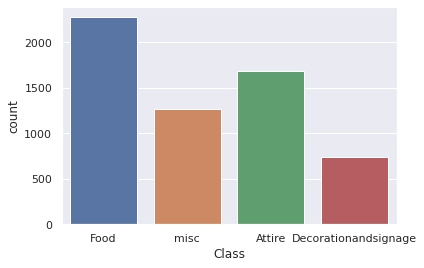

In [0]:
# Display countplot for different classes in training data
sns.set(style="darkgrid")
ax = sns.countplot(x="Class", data=train_true_label_df)

In [0]:
# Convert categorical classes into numerical representations
train_true_label_df['Class_enc'] = train_true_label_df['Class'].factorize()[0]
train_true_label_df.groupby(['Class','Class_enc']).size().reset_index().rename(columns={0:'Count'})

,Class,Class_enc,Count
0,Attire,2,1691
1,Decorationandsignage,3,743
2,Food,0,2278
3,misc,1,1271


#### Create feature matrix for training images

In [0]:
image_group = []
for file in train_true_label_df['Image']:

    # Set file path for input image
    file_path = train_img_path + "/" + file
    
    # Read input image using OpenCV
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize the input image
    normalized_img= img.flatten()
    normalized_img = normalized_img / 255
    img = normalized_img.reshape(img.shape[0], img.shape[1], 3)

    image_group.append(img)

print(len(image_group))

5983


In [0]:
# Get the max image shape
max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))
print(max_shape)

min_shape = tuple(min(image.shape[x] for image in image_group) for x in range(3))
print(min_shape)

(235, 80, 3)
(20, 80, 3)


In [0]:
# Construct an image batch object
image_batch = np.zeros((len(image_group),) + (310, 80, 3), dtype='float32')
print(image_batch.shape)

(5983, 310, 80, 3)


In [0]:
# Copy all images to the upper left part of the image batch object
for image_index, image in enumerate(image_group):
    image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

In [0]:
Xtrain = np.copy(image_batch)
print("Xtrain shape: {}".format(Xtrain.shape))

Xtrain shape: (5983, 310, 80, 3)


#### Create feature matrix for test images

In [0]:
# Read prediction file
prediction_df = pd.read_csv(prediction_file)
prediction_df.head()

,Image
0,image6245.jpg
1,image10409.jpg
2,image8692.jpg
3,image10517.jpg
4,image2580.jpg


In [0]:
image_group = []
for file in prediction_df['Image']:

    # Set file path for input image
    file_path = test_img_path + "/" + file
    
    # Read input image using OpenCV
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize the input image
    normalized_img= img.flatten()
    normalized_img = normalized_img / 255
    img = normalized_img.reshape(img.shape[0], img.shape[1], 3)

    image_group.append(img)

print(len(image_group))

3219


In [0]:
# Get the max image shape
max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))
print(max_shape)

min_shape = tuple(min(image.shape[x] for image in image_group) for x in range(3))
print(min_shape)

(305, 80, 3)
(23, 80, 3)


In [0]:
# Construct an image batch object
image_batch = np.zeros((len(image_group),) + (310, 80, 3), dtype='float32')
print(image_batch.shape)

(3219, 310, 80, 3)


In [0]:
# Copy all images to the upper left part of the image batch object
for image_index, image in enumerate(image_group):
    image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

In [0]:
Xpredict = np.copy(image_batch)
print("Xpredict shape: {}".format(Xpredict.shape))

Xpredict shape: (3219, 310, 80, 3)


#### Create true labels vector for training images

In [0]:
Ytrain = np.array([train_true_label_df['Class_enc'].to_numpy()]).T
print("Ytrain shape: {}".format(Ytrain.shape))

Ytrain shape: (5983, 1)


#### Split training data into train/test datasets

In [0]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
for train_index, test_index in sss.split(Xtrain, Ytrain):
    train_x, test_x = Xtrain[train_index], Xtrain[test_index]
    train_y, test_y = Ytrain[train_index], Ytrain[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (5384, 310, 80, 3)
train_y shape: (5384, 1)

------------------------- Test Dataset -------------------------
test_x shape: (599, 310, 80, 3)
test_y shape: (599, 1)


In [0]:
train_df = pd.DataFrame({'Class': train_y[:, 0]})
train_df.groupby(['Class']).size().reset_index().rename(columns={0:'Count'})

,Class,Count
0,0,2050
1,1,1144
2,2,1522
3,3,668


In [0]:
test_df = pd.DataFrame({'Class': test_y[:, 0]})
test_df.groupby(['Class']).size().reset_index().rename(columns={0:'Count'})

,Class,Count
0,0,228
1,1,127
2,2,169
3,3,75


#### Convert train_y/test_y into one-hot encode matrix

In [0]:
train_y = tf.keras.utils.to_categorical(train_y, 4)
test_y = tf.keras.utils.to_categorical(test_y, 4)

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (5384, 310, 80, 3)
train_y shape: (5384, 4)

------------------------- Test Dataset -------------------------
test_x shape: (599, 310, 80, 3)
test_y shape: (599, 4)


## Save the datasets in NPZ file (for reusability)

In [0]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/dataset/Auto_Tag_Gala_Images_dataset.npz',
                    Xtrain=train_x, Ytrain=train_y,
                    Xtest=test_x, Ytest=test_y,
                    Xpredict=Xpredict)

## Load datasets from the NPZ file

In [9]:
processed_dataset = np.load('/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/dataset/Auto_Tag_Gala_Images_dataset.npz', allow_pickle=True)

Xtrain, Ytrain = processed_dataset['Xtrain'], processed_dataset['Ytrain']
Xtest, Ytest = processed_dataset['Xtest'], processed_dataset['Ytest']
Xpredict = processed_dataset['Xpredict']

print("------------------------- Training Dataset -------------------------")
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain shape: (5384, 310, 80, 3)
Ytrain shape: (5384, 4)

------------------------- Test Dataset -------------------------
Xtest shape: (599, 310, 80, 3)
Ytest shape: (599, 4)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (3219, 310, 80, 3)


## Build the model

In [0]:
def get_f1(y_true, y_pred):

    # Calculate all positives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # Calculate precision and recall
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    # Calculate F1 score
    f1_val = 200*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
def cnn_model():
    
    # Input Layer
    x_input = Input(shape=(None, None, 3), name='INPUT')

    # CONV Layer 1
    x = SeparableConv2D(filters=32, kernel_size=(7, 7), padding='same', kernel_regularizer=l2(0.5), name='CONV-1')(x_input)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MAXPOOL-1')(x)
    x = Dropout(rate=0.40, name='DROPOUT_CONV-1')(x)

    # CONV Layer 2
    x = SeparableConv2D(filters=64, kernel_size=(5, 5), padding='same', kernel_regularizer=l2(0.5), name='CONV-2')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MAXPOOL-2')(x)
    x = Dropout(rate=0.40, name='DROPOUT_CONV-2')(x)
    
    # CONV Layer 3
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.5), name='CONV-3A')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-3A')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.5), name='CONV-3B')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-3B')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MAXPOOL-3')(x)
    x = Dropout(rate=0.40, name='DROPOUT_CONV-3')(x)

    # CONV Layer 4
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.5), name='CONV-4A')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-4A')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.5), name='CONV-4B')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-4B')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MAXPOOL-4')(x)
    x = Dropout(rate=0.40, name='DROPOUT_CONV-4')(x)

    # CONV Layer 5
    x = SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.5), name='CONV-5A')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-5A')(x)
    x = SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.5), name='CONV-5B')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_CONV-5B')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MAXPOOL-5')(x)
    x = Dropout(rate=0.40, name='DROPOUT_CONV-5')(x)

    # Fully Connected Layers
    x = SeparableConv2D(filters=1024, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(0.5), name='FC-1')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1, name='BN_FC-1')(x)
    x = Dropout(rate=0.40, name='DROPOUT_FC-1')(x)

    # Output Layer
    x = SeparableConv2D(filters=4, kernel_size=(1, 1), name='OUTPUT')(x)
    x = BatchNormalization(axis=-1, name='BN_OUTPUT')(x)
    x = GlobalMaxPooling2D()(x)
    x = Activation('softmax')(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='GalaImagesClassifier')
    return model

In [0]:
# Define the model hyperparameters
max_iterations = 100
mini_batch_size = 64
init_lr = 1e-1
#schedule = StepDecay(initAlpha=1e-1, factor=0.10, dropEvery=20)
schedule = PolynomialDecay(maxEpochs=max_iterations, initAlpha=1e-1, power=3)
callbacks = [LearningRateScheduler(schedule)]

In [13]:
# Create the model
model = cnn_model()

# Compile model to configure the learning process
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=init_lr,),
              metrics=[get_f1, 'accuracy'])

# Display details of all CNN layers
model.summary()

Model: "GalaImagesClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, None, None, 3)]   0         
_________________________________________________________________
CONV-1 (SeparableConv2D)     (None, None, None, 32)    275       
_________________________________________________________________
activation (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
BN_CONV-1 (BatchNormalizatio (None, None, None, 32)    128       
_________________________________________________________________
MAXPOOL-1 (MaxPooling2D)     (None, None, None, 32)    0         
_________________________________________________________________
DROPOUT_CONV-1 (Dropout)     (None, None, None, 32)    0         
_________________________________________________________________
CONV-2 (SeparableConv2D)     (None, None, None

In [14]:
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain, Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

Epoch 1/25
 5/85 [>.............................] - ETA: 3:57 - loss: 1.7122 - get_f1: 13.6824 - accuracy: 0.2313

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-18213824571a>", line 5, in <module>
    batchSize=mini_batch_size)
  File "/content/drive/My Drive/Colab Notebooks/Auto-tag Images of the Gala/learningratefinder.py", line 152, in find
    verbose=verbose)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 785, in fit
    tmp_logs = train_function(iterator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 580, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 611, in _call
    re

KeyboardInterrupt: ignored

In [0]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [0]:
# Define 5-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=10)
cvscores = []
y_pred = 0
loss_values = {}
acc_values = {}
f1_values = {}

In [0]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1
    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    # Create the model
    model = cnn_model()

    # Compile model to configure the learning process
    model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=init_lr), metrics=[get_f1, 'accuracy'])

    # Configure learning rate schedule
    schedule = PolynomialDecay(maxEpochs=max_iterations, initAlpha=1e-2, power=3)
    callbacks = [LearningRateScheduler(schedule)]

    # Fit the model
    '''
    history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                    callbacks=callbacks, shuffle=False,
                    epochs=max_iterations, validation_data=(val_x, val_y))
    '''
    
    history = model.fit_generator(datagen.flow(train_x, train_y, batch_size=mini_batch_size),
                              steps_per_epoch=int(np.ceil(train_x.shape[0] / float(mini_batch_size))),
                              callbacks=callbacks, workers=5, shuffle=False,
                              epochs=max_iterations, validation_data=(val_x, val_y))
    
    # Store the score values on validation dataset
    scores = model.evaluate(x=Xtest, y=Ytest, verbose=0)
    print("Counter {}: \nTest Loss: {} \nTest F1 Score: {} \n Test Accuracy: {}".format(counter, scores[0], scores[1], scores[2]))
    cvscores.append(scores[1])

    # Run predictions
    pred1 = model.predict(x=Xtest)
    y_pred += pred1

    # Store the history object values for learning curves plotting
    loss_values["train_loss_"+str(counter)] = history.history['loss']
    loss_values["val_loss_"+str(counter)] = history.history['val_loss']
    f1_values["train_f1_"+str(counter)] = history.history['get_f1']
    f1_values["val_f1_"+str(counter)] = history.history['val_get_f1']
    acc_values["train_acc_"+str(counter)] = history.history['accuracy']
    acc_values["val_acc_"+str(counter)] = history.history['val_accuracy']

print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))
y_pred /= float(counter)

Epoch 1/100
10/68 [===>..........................] - ETA: 13s - loss: 1.4963 - get_f1: 20.7463 - accuracy: 0.3578

KeyboardInterrupt: ignored

In [0]:
print(classification_report(Ytest.argmax(axis=1), y_pred.argmax(axis=1)))

(509, 4)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.00      0.00      0.00       108
           2       0.00      0.00      0.00       144
           3       0.12      1.00      0.22        63

    accuracy                           0.12       509
   macro avg       0.03      0.25      0.06       509
weighted avg       0.02      0.12      0.03       509



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Plot the learning curves to show the learning process

In [0]:
N = np.arange(0, max_iterations)

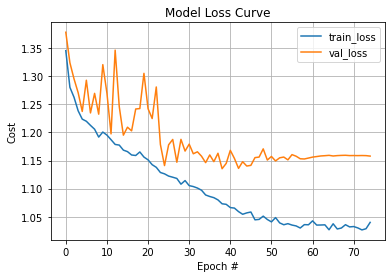

In [0]:
plt.plot(N, loss_values["train_loss_1"], label='train_loss_1')
plt.plot(N, loss_values["train_loss_2"], label='train_loss_2')
plt.plot(N, loss_values["train_loss_3"], label='train_loss_3')
plt.plot(N, loss_values["train_loss_4"], label='train_loss_4')
plt.plot(N, loss_values["train_loss_5"], label='train_loss_5')
plt.plot(N, loss_values["val_loss_1"], label='val_loss_1')
plt.plot(N, loss_values["val_loss_2"], label='val_loss_2')
plt.plot(N, loss_values["val_loss_3"], label='val_loss_3')
plt.plot(N, loss_values["val_loss_4"], label='val_loss_4')
plt.plot(N, loss_values["val_loss_5"], label='val_loss_5')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [0]:
plt.plot(N, acc_values['train_acc_1'], label='train_acc_1')
plt.plot(N, acc_values['train_acc_2'], label='train_acc_2')
plt.plot(N, acc_values['train_acc_3'], label='train_acc_3')
plt.plot(N, acc_values['train_acc_4'], label='train_acc_4')
plt.plot(N, acc_values['train_acc_5'], label='train_acc_5')
plt.plot(N, acc_values['val_acc_1'], label='val_acc_1')
plt.plot(N, acc_values['val_acc_2'], label='val_acc_2')
plt.plot(N, acc_values['val_acc_3'], label='val_acc_3')
plt.plot(N, acc_values['val_acc_4'], label='val_acc_4')
plt.plot(N, acc_values['val_acc_5'], label='val_acc_5')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.title("Model Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

NameError: ignored

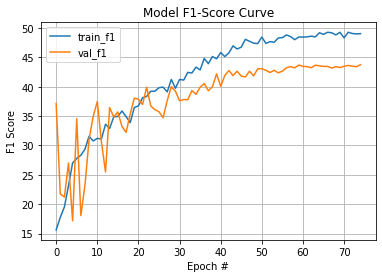

In [0]:
plt.plot(N, f1_values['train_f1_1'], label='train_f1_1')
plt.plot(N, f1_values['train_f1_2'], label='train_f1_2')
plt.plot(N, f1_values['train_f1_3'], label='train_f1_3')
plt.plot(N, f1_values['train_f1_4'], label='train_f1_4')
plt.plot(N, f1_values['train_f1_5'], label='train_f1_5')
plt.plot(N, f1_values['val_f1_1'], label='val_f1_1')
plt.plot(N, f1_values['val_f1_2'], label='val_f1_2')
plt.plot(N, f1_values['val_f1_3'], label='val_f1_3')
plt.plot(N, f1_values['val_f1_4'], label='val_f1_4')
plt.plot(N, f1_values['val_f1_5'], label='val_f1_5')
plt.ylabel('F1 Score')
plt.xlabel('Epoch #')
plt.title("Model F1-Score Curve")
plt.legend()
plt.grid()
plt.show()

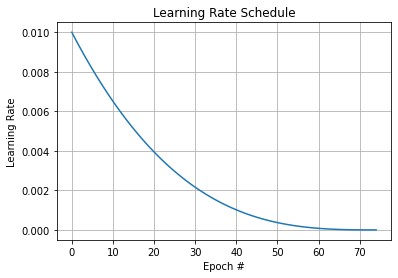

In [0]:
schedule.plot(N)